# Python-AWIPS Data Access 

### Table of Contents
1. <a href="#intro">Introduction to Python-AWIPS</a>
1. <a href="#connect">Connecting to EDEX</a>
1. <a href="#datatypes">Exploring Available Data Types</a>
1. <a href="#request">Creating a Data Request</a>
1. <a href="#explore">Exploring Available Data</a>
1. <a href="#times">Working with Times</a>
1. <a href="#getdata">Retrieving the Data</a>
1. <a href="#xarray">Converting to xarray</a>

<a name="intro"></a>
## Introduction to Python-AWIPS

[Python-AWIPS](https://unidata.github.io/python-awips/) is a package that provides access to the AWIPS (Advanced Weather Interactive Processing System) data through the EDEX (Environmental Data EXchange) server. AWIPS is a weather display and analysis package developed by the National Weather Service for operational forecasting.

The **DataAccessLayer** is the primary interface for requesting meteorological data from an EDEX server. It provides methods for:

- Discovering what data types are available
- Exploring locations (models, sites, etc.)
- Finding available parameters and levels
- Querying available times
- Retrieving the actual data

In this notebook, we'll walk through the complete workflow from connecting to an EDEX server to getting data into an xarray Dataset that you can use for analysis and visualization.

<a name="connect"></a>
## Connecting to EDEX

The first step is to import the `DataAccessLayer` and establish a connection to an EDEX server. Unidata provides a publicly accessible cloud EDEX server for training and research purposes.

In [1]:
from awips.dataaccess import DataAccessLayer

# Connect to Unidata's cloud EDEX server
edex_url = "edex-cloud.unidata.ucar.edu"
DataAccessLayer.changeEDEXHost(edex_url)

print(f"Connected to EDEX server: {edex_url}")

Connected to EDEX server: edex-cloud.unidata.ucar.edu


<a name="datatypes"></a>
## Exploring Available Data Types

The `getSupportedDatatypes()` method returns a list of all data types available on the connected EDEX server. These represent different categories of meteorological data.

In [2]:
# Get and display all available data types
data_types = DataAccessLayer.getSupportedDatatypes()
data_types.sort()
list(data_types)

['acars',
 'airep',
 'binlightning',
 'bufrmosavn',
 'bufrmoseta',
 'bufrmosgfs',
 'bufrmoshpc',
 'bufrmoslamp',
 'bufrmosmrf',
 'bufrua',
 'climate',
 'common_obs_spatial',
 'dmw',
 'gfe',
 'gfeeditarea',
 'grid',
 'ldadmesonet',
 'maps',
 'modelsounding',
 'obs',
 'pirep',
 'practicewarning',
 'profiler',
 'radar',
 'radar_spatial',
 'satellite',
 'sfcobs',
 'topo',
 'warning']

Some commonly used data types include:

| Data Type | Description |
|-----------|-------------|
| `grid` | Gridded model data (GFS, NAM, RAP, HRRR, etc.) |
| `obs` | Surface observations (METAR) |
| `satellite` | Satellite imagery |
| `radar` | NEXRAD Level 3 radar data |
| `modelsounding` | Model sounding profiles |
| `bufrua` | Upper air observations |
| `warning` | NWS watches, warnings, and advisories |

<a name="request"></a>
## Creating a Data Request

To request data, we create a new data request object and specify what we want. The workflow typically involves:

1. Create a new request with `newDataRequest()`
2. Set the data type with `setDatatype()`
3. Optionally set location, parameters, levels, etc.

For this example, we'll request **grid** data, which contains model output like the GFS.

In [3]:
# Create a new data request for grid data
request = DataAccessLayer.newDataRequest()
request.setDatatype("grid")

print(f"Created request for datatype: grid")

Created request for datatype: grid


<a name="explore"></a>
## Exploring Available Data

Before we can request specific data, we need to know what's available. The DataAccessLayer provides several methods for exploring the data catalog.

### Available Locations

For grid data, "locations" correspond to different models or data sources. Use `getAvailableLocationNames()` to see what's available.

In [4]:
# Get available locations (models) for grid data
locations = DataAccessLayer.getAvailableLocationNames(request)
locations.sort()
list(locations)

['AK-NAM11',
 'BHP-ALPW',
 'BLENDED-PCT_TPW-Sat',
 'BLENDED-Rain_Rate-Sat',
 'BLENDED-TPW-Sat',
 'ESTOFS',
 'ESTOFS-other',
 'ETSS',
 'FFG-ALR',
 'FFG-FWR',
 'FFG-KRF',
 'FFG-MSR',
 'FFG-ORN',
 'FFG-PTR',
 'FFG-RHA',
 'FFG-RSA',
 'FFG-STR',
 'FFG-TAR',
 'FFG-TIR',
 'FFG-TUA',
 'GFS1p0',
 'GFS20',
 'GOES-East_Gridded_Turbulence',
 'GOES-West_Gridded_Turbulence',
 'GlobalWave',
 'HFR-EAST_6KM',
 'HFR-EAST_PR_6KM',
 'HFR-US_EAST_DELAWARE_1KM',
 'HFR-US_EAST_FLORIDA_2KM',
 'HFR-US_EAST_NORTH_2KM',
 'HFR-US_EAST_SOUTH_2KM',
 'HFR-US_EAST_VIRGINIA_1KM',
 'HFR-US_HAWAII_1KM',
 'HFR-US_HAWAII_2KM',
 'HFR-US_HAWAII_6KM',
 'HFR-US_WEST_500M',
 'HFR-US_WEST_CENCAL_2KM',
 'HFR-US_WEST_LOSANGELES_1KM',
 'HFR-US_WEST_LOSOSOS_1KM',
 'HFR-US_WEST_NORTH_2KM',
 'HFR-US_WEST_SANFRAN_1KM',
 'HFR-US_WEST_SOCAL_2KM',
 'HFR-US_WEST_WASHINGTON_1KM',
 'HFR-WEST_6KM',
 'HPCqpfNDFD',
 'HREF-AK',
 'HREF-HI',
 'HREF-SJU',
 'HREF-US',
 'HRRR',
 'HRRR-Smoke',
 'HiResW-ARW',
 'HiResW-ARW-AK',
 'HiResW-ARW-GU',
 'HiRe

Some common model identifiers you might see:

| Location Name | Description |
|---------------|-------------|
| `GFS20` | Global Forecast System (20km) |
| `NAM12` | North American Mesoscale (12km) |
| `RAP13` | Rapid Refresh (13km) |
| `HRRR` | High Resolution Rapid Refresh |
| `MRMS_1000` | Multi-Radar Multi-Sensor |

Let's select the GFS 20km model for our example.

In [5]:
# Set the location (model) we want to use
request.setLocationNames("GFS20")

print("Selected model: GFS20")

Selected model: GFS20


### Available Parameters

Now that we've specified a model, we can see what parameters (variables) are available.

In [6]:
# Get available parameters for the selected model
params = DataAccessLayer.getAvailableParameters(request)
params.sort()

# Display first 30 parameters (there are many!)
print(f"Total parameters available: {len(params)}")
print("\nFirst 30 parameters:")
list(params[:30])

Total parameters available: 497

First 30 parameters:


['-10C Hgt AGL',
 '-12 to -18C Omega',
 '-12 to -18C Thickness',
 '-12C Hgt',
 '-18C Hgt',
 '-20C Hgt AGL',
 '-30C Hgt AGL',
 '0 to 3km Line Normal Shear Vectors (Left)',
 '0 to 3km Line Normal Shear Vectors (Right)',
 '0-10km Blk Shr Mag',
 '0-10km Blk Shr Vect',
 '0-1km Blk Shr Mag',
 '0-1km Blk Shr Vect',
 '0-1km EHI',
 '0-1km Helicity',
 '0-1km Mixing Ratio',
 '0-1km Moisture Convergence',
 '0-1km Theta-E',
 '0-1km Theta-E Adv',
 '0-1km Wind Streamlines',
 '0-2km Blk Shr Mag',
 '0-2km Blk Shr Vect',
 '0-2km EHI',
 '0-2km Helicity',
 '0-3km Blk Shr Mag',
 '0-3km Blk Shr Vect',
 '0-3km EHI',
 '0-3km Helicity',
 '0-3km LR',
 '0-3km MLCAPE']

Some commonly used parameters include:

| Parameter | Description |
|-----------|-------------|
| `T` | Temperature |
| `GH` | Geopotential Height |
| `RH` | Relative Humidity |
| `Wind` | Wind (vector) |
| `TP` | Total Precipitation |
| `CAPE` | Convective Available Potential Energy |

Let's select Temperature (`T`) for our example.

In [7]:
# Set the parameter we want
request.setParameters("T")

print("Selected parameter: T (Temperature)")

Selected parameter: T (Temperature)


### Available Levels

For 3D data like model output, we also need to specify which vertical level(s) we want. The `getAvailableLevels()` method shows what's available.

In [8]:
# Get available levels for the selected parameter
levels = DataAccessLayer.getAvailableLevels(request)

# Display first 20 levels
print(f"Total levels available: {len(levels)}")
print("\nSample levels:")
for lvl in levels[:20]:
    print(f"  {lvl}")

Total levels available: 258

Sample levels:
  700.0MB
  1000.0FHAG
  0.0SFC
  2000.0_5000.0FHAG
  0.0_3000.0FHAG
  2.0FHAG
  1000.0_400.0MB
  850.0MB
  0.0_6000.0FHAG
  850.0_300.0MB
  250.0MB
  500.0MB
  925.0MB
  700.0_500.0MB
  340.0_350.0K
  290.0_300.0K
  700.0_600.0MB
  700.0_300.0MB
  320.0Ke
  3962.4FHAG


Level notation guide:

| Suffix | Meaning |
|--------|--------|
| `MB` | Pressure level in millibars |
| `SFC` | Surface |
| `FHAG` | Fixed Height Above Ground (meters) |
| `BL` | Boundary Layer |
| `TROP` | Tropopause |
| `K` | Isentropic (Kelvin) |

Let's select the surface level (`0.0SFC`).

In [9]:
# Set the level we want
request.setLevels("0.0SFC")

print("Selected level: 0.0SFC (Surface)")

Selected level: 0.0SFC (Surface)


<a name="times"></a>
## Working with Times

Model data includes multiple forecast times. Python-AWIPS provides methods to work with these:

- `getAvailableTimes(request, True)` - Returns available **run times** (initialization times)
- `getAvailableTimes(request)` - Returns all available times (run + forecast)
- `getForecastRun(cycle, times)` - Returns times for a specific forecast cycle

In [10]:
# Get available forecast cycles (run times)
cycles = DataAccessLayer.getAvailableTimes(request, True)

print(f"Number of available forecast cycles: {len(cycles)}")
print(f"\nMost recent cycle: {cycles[-1]}")

Number of available forecast cycles: 3

Most recent cycle: 2026-01-25 06:00:00


In [11]:
# Get all available times
times = DataAccessLayer.getAvailableTimes(request)

# Get the forecast run for the most recent cycle
fcst_run = DataAccessLayer.getForecastRun(cycles[-1], times)

print(f"Number of forecast times in latest run: {len(fcst_run)}")
print("\nFirst 10 forecast times:")
for t in fcst_run[:10]:
    print(f"  {t.getRefTime()} : {t.getFcstTime()} seconds ({t.getFcstTime()/3600:.0f} hours)")

Number of forecast times in latest run: 24

First 10 forecast times:
  2026-01-25 06:00:00.000 : 0 seconds (0 hours)
  2026-01-25 06:00:00.000 : 10800 seconds (3 hours)
  2026-01-25 06:00:00.000 : 21600 seconds (6 hours)
  2026-01-25 06:00:00.000 : 32400 seconds (9 hours)
  2026-01-25 06:00:00.000 : 43200 seconds (12 hours)
  2026-01-25 06:00:00.000 : 54000 seconds (15 hours)
  2026-01-25 06:00:00.000 : 64800 seconds (18 hours)
  2026-01-25 06:00:00.000 : 75600 seconds (21 hours)
  2026-01-25 06:00:00.000 : 86400 seconds (24 hours)
  2026-01-25 06:00:00.000 : 97200 seconds (27 hours)


<a name="getdata"></a>
## Retrieving the Data

Now we're ready to actually retrieve the data. For gridded data, we use `getGridData()`. This returns a list of grid objects, each containing the data array and metadata.

In [12]:
# Request data for the first forecast time (analysis, 0 hour)
response = DataAccessLayer.getGridData(request, [fcst_run[0]])

print(f"Number of grid objects returned: {len(response)}")

Number of grid objects returned: 1


In [13]:
# Extract information from the first grid object
grid = response[0]

print("Grid Metadata:")
print(f"  Model:     {grid.getLocationName()}")
print(f"  Parameter: {grid.getParameter()}")
print(f"  Level:     {grid.getLevel()}")
print(f"  Unit:      {grid.getUnit()}")
print(f"  Time:      {grid.getDataTime()}")
print(f"  Forecast:  {grid.getDataTime().getFcstTime()/3600:.0f} hours")

Grid Metadata:
  Model:     GFS20
  Parameter: T
  Level:     0.0SFC
  Unit:      K
  Time:      2026-01-25 06:00:00 (0)
  Forecast:  0 hours


In [14]:
# Get the raw data array and coordinates
data = grid.getRawData()
lons, lats = grid.getLatLonCoords()

print(f"Data shape: {data.shape}")
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")
print(f"\nData range: {data.min():.2f} to {data.max():.2f} {grid.getUnit()}")

Data shape: (257, 369)
Longitude shape: (257, 369)
Latitude shape: (257, 369)

Data range: 233.54 to 300.34 K


<a name="xarray"></a>
## Converting to xarray

While python-awips returns numpy arrays, it's often more convenient to work with xarray for analysis and visualization. xarray provides labeled dimensions, coordinate-aware operations, and integrates well with other tools like MetPy.

We can create an xarray Dataset from the numpy arrays returned by python-awips.

In [15]:
import xarray as xr
import numpy as np

# Create an xarray DataArray from the grid data
da = xr.DataArray(
    data=data,
    dims=['y', 'x'],
    coords={
        'latitude': (['y', 'x'], lats),
        'longitude': (['y', 'x'], lons),
    },
    attrs={
        'units': grid.getUnit(),
        'long_name': grid.getParameter(),
        'level': str(grid.getLevel()),
        'model': grid.getLocationName(),
        'valid_time': str(grid.getDataTime()),
    },
    name=grid.getParameter()
)

da

<xarray.DataArray 'T' (y: 257, x: 369)> Size: 379kB
array([[278.044, 278.044, 277.944, ..., 272.144, 272.344, 272.444],
       [278.144, 278.144, 277.944, ..., 272.044, 272.144, 272.344],
       [278.144, 278.144, 278.044, ..., 272.044, 272.144, 272.144],
       ...,
       [297.344, 297.444, 297.444, ..., 299.444, 299.544, 299.544],
       [297.444, 297.444, 297.444, ..., 299.344, 299.444, 299.444],
       [297.444, 297.544, 297.544, ..., 299.244, 299.244, 299.244]],
      shape=(257, 369), dtype='>f4')
Coordinates:
    latitude   (y, x) >f4 379kB 54.54 54.6 54.66 54.73 ... 14.41 14.37 14.33
    longitude  (y, x) >f4 379kB -152.9 -152.6 -152.4 ... -65.45 -65.27 -65.09
Dimensions without coordinates: y, x
Attributes:
    units:       K
    long_name:   T
    level:       0.0SFC
    model:       GFS20
    valid_time:  2026-01-25 06:00:00 (0)

### Creating a Complete Dataset

For a more complete xarray Dataset with proper time coordinates, we can request multiple forecast times and combine them.

In [16]:
from datetime import datetime, timedelta

# Request data for the first 5 forecast times
num_times = 5
response = DataAccessLayer.getGridData(request, fcst_run[:num_times])

# Build arrays for the Dataset
data_list = []
times_list = []

for grid in response:
    data_list.append(grid.getRawData())
    # Parse the time from the grid object
    ref_time = grid.getDataTime().getRefTime()
    fcst_seconds = grid.getDataTime().getFcstTime()
    # Create a proper datetime
    valid_time = datetime.strptime(str(ref_time)[:19], '%Y-%m-%d %H:%M:%S') + timedelta(seconds=fcst_seconds)
    times_list.append(valid_time)

# Stack data into a 3D array (time, y, x)
data_3d = np.stack(data_list, axis=0)

print(f"Combined data shape: {data_3d.shape}")

Combined data shape: (5, 257, 369)


In [17]:
# Create the xarray Dataset
ds = xr.Dataset(
    data_vars={
        grid.getParameter(): (['time', 'y', 'x'], data_3d, {
            'units': grid.getUnit(),
            'long_name': 'Temperature',
            'level': str(grid.getLevel()),
        })
    },
    coords={
        'time': times_list,
        'latitude': (['y', 'x'], lats),
        'longitude': (['y', 'x'], lons),
    },
    attrs={
        'model': grid.getLocationName(),
        'source': 'EDEX via python-awips',
    }
)

ds

<xarray.Dataset> Size: 3MB
Dimensions:    (time: 5, y: 257, x: 369)
Coordinates:
  * time       (time) datetime64[us] 40B 2026-01-25T15:00:00 ... 2026-01-25T1...
    latitude   (y, x) >f4 379kB 54.54 54.6 54.66 54.73 ... 14.41 14.37 14.33
    longitude  (y, x) >f4 379kB -152.9 -152.6 -152.4 ... -65.45 -65.27 -65.09
Dimensions without coordinates: y, x
Data variables:
    T          (time, y, x) float32 2MB 277.7 277.7 277.6 ... 299.5 299.5 299.6
Attributes:
    model:    GFS20
    source:   EDEX via python-awips

### Using the xarray Dataset

Now we have a proper xarray Dataset that we can use with all of xarray's powerful features.

In [18]:
from metpy.units import units

ds = ds.metpy.parse_cf()

ds.T.metpy.units

<Unit('kelvin')>

In [19]:
# Select data by time
temp_first = ds['T'].isel(time=0)
print(f"Data at first time step:")
print(f"  Valid time: {temp_first.time.values}")
print(f"  Shape: {temp_first.shape}")

Data at first time step:
  Valid time: 2026-01-25T15:00:00.000000
  Shape: (257, 369)


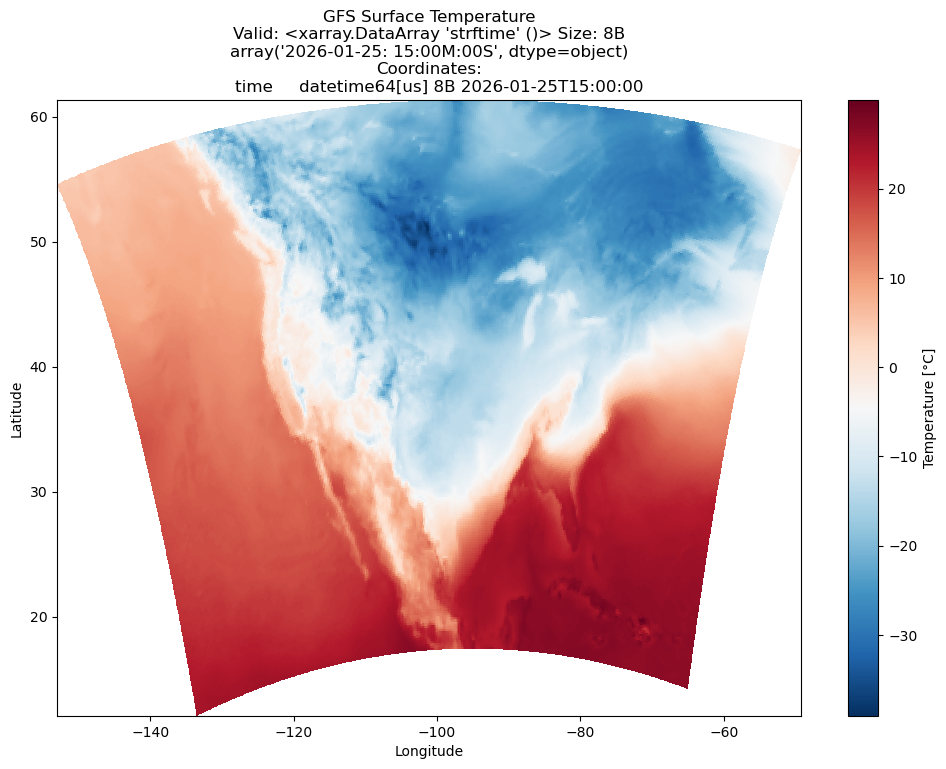

In [20]:
# Quick visualization
import matplotlib.pyplot as plt

# Convert from Kelvin to Celsius for plotting
temp_c = ds['T'].isel(time=0).metpy.convert_units('degC')

fig, ax = plt.subplots(figsize=(12, 8))
img = ax.pcolormesh(temp_c.longitude, temp_c.latitude, temp_c, cmap='RdBu_r', shading='auto')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'GFS Surface Temperature\nValid: {temp_c.metpy.time.dt.strftime("%Y-%m-%d: %H:%MM:%SS")}')
cbar = plt.colorbar(img, ax=ax, label=f'Temperature [{temp_c.metpy.units:~P}]')
plt.show()

## Summary

In this notebook, we learned how to:

1. **Connect** to an EDEX server using `DataAccessLayer.changeEDEXHost()`
2. **Explore** available data types with `getSupportedDatatypes()`
3. **Create** a data request with `newDataRequest()` and configure it
4. **Discover** available locations, parameters, and levels
5. **Query** available times and forecast runs
6. **Retrieve** data with `getGridData()`
7. **Convert** the data to an xarray Dataset for analysis

### Key DataAccessLayer Methods

| Method | Purpose |
|--------|--------|
| `changeEDEXHost(url)` | Connect to an EDEX server |
| `getSupportedDatatypes()` | List available data types |
| `newDataRequest()` | Create a new request object |
| `getAvailableLocationNames(request)` | Get available locations/models |
| `getAvailableParameters(request)` | Get available parameters |
| `getAvailableLevels(request)` | Get available vertical levels |
| `getAvailableTimes(request)` | Get available times |
| `getForecastRun(cycle, times)` | Get times for a specific run |
| `getGridData(request, times)` | Retrieve gridded data |
| `getGeometryData(request, times)` | Retrieve point/geometry data |

## Additional Resources

### Python-AWIPS Documentation
- [Python-AWIPS Home](https://unidata.github.io/python-awips/)
- [Available Data Types](https://unidata.github.io/python-awips/datatypes.html)
- [Example Notebooks](https://unidata.github.io/python-awips/examples/)

### Related Examples
- [Grid Levels and Parameters](https://unidata.github.io/python-awips/examples/generated/Grid_Levels_and_Parameters.html)
- [Colorized Grid Data](https://unidata.github.io/python-awips/examples/generated/Colorized_Grid_Data.html)
- [Satellite Imagery](https://unidata.github.io/python-awips/examples/generated/Satellite_Imagery.html)

### xarray and MetPy
- [xarray Documentation](https://docs.xarray.dev/)
- [MetPy with xarray](https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html)